# Wikipedia Views Expansion

The goal of this notebook is to use the data from langviews to expand the data about the views on the environment topic to include data from 2015 to 2022 (instead of 2019 to 2021).

## Import

In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import os
import time
from statsmodels.stats import diagnostic
from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf

from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.wait import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC

## Data loading

In [2]:
df = pd.read_csv('Data/topics_linked.csv.xz')

In [3]:
df_env = df[df["STEM.Earth and environment"] == True]
len(df_env)

In [4]:
df_env.loc[3722584:]

## Extraction

In [5]:
def init_driver():
    """
    Init a firefox driver that download files in the folder 'Data/Additional/langviews/raw/'
    :return: a firefox driver
    """
    options = webdriver.FirefoxOptions()
    options.binary_location = "C:\\Program Files\\Mozilla Firefox\\firefox.exe"
    options.set_preference("browser.download.dir", 'C:\\Users\\Rabid\\Desktop\\ada-project\\Data\\Additional\\langviews\\raw')

    options.set_preference( "browser.download.manager.showWhenStarting", False )
    options.set_preference( "browser.download.folderList", 2 )
    options.set_preference( "browser.download.useDownloadDir", True )

    options.set_preference("browser.helperApps.neverAsk.saveToDisk", "text/csv")
    options.set_preference("browser.helperApps.neverAsk.openFile", "text/csv")

    return webdriver.Firefox(executable_path='C:\selenium\geckodriver.exe', options=options)


def download(driver, wiki_title):
    """
    Download a csv containing the views day by day of the specified wikipedia page from 01-07-2015 to 20-11-2022
    :param driver: a selenium firefox driver
    :param wiki_title: the wikipedia page
    """
    driver.get("https://pageviews.wmcloud.org/langviews/?project=en.wikipedia.org&platform=all-access&agent=user&start=2015-07-01&end=2022-11-20&sort=views&direction=1&view=list&page="+wiki_title)

    button = WebDriverWait(driver, 20).until(
        EC.visibility_of_element_located((By.XPATH, '//button[normalize-space()="Download"]'))
    )

    button.click()

    csv = driver.find_element(By.CLASS_NAME, 'download-csv')
    csv.click()

    time.sleep(1)


def rename(new_name):
    """
    Find a langviews csv in the 'Data/Additional/langviews/raw/' folder, rename it to the specified name and move the file to the folder 'Data/Additional/langviews/processed/'
    :param new_name: the new name of the langviews csv
    """
    files = os.listdir('Data/Additional/langviews/raw/')
    for file in files:
        if file.startswith('langviews'):
            full_name = "langviews-"+new_name+".csv"
            os.rename('Data/Additional/langviews/raw/'+file, 'Data/Additional/langviews/processed/'+full_name)
            break

In [6]:
driver = init_driver()

In [7]:
from selenium.common.exceptions import TimeoutException, ElementClickInterceptedException

for _, col in df_env.loc[3722584:].iterrows():
    title = col.loc["index"]
    try:
        download(driver, title)
    except TimeoutException:
        print("Error with {}".format(title))
    except ElementClickInterceptedException:
        print("Error with {}".format(title))

    rename(title.lower().replace(":", "").replace("?", "").replace('/', '_').replace('"', ""))

'from selenium.common.exceptions import TimeoutException, ElementClickInterceptedException\n\nfor _, col in df_env.loc[3722584:].iterrows():\n    title = col.loc["index"]\n    try:\n        download(driver, title)\n    except TimeoutException:\n        print("Error with {}".format(title))\n    except ElementClickInterceptedException:\n        print("Error with {}".format(title))\n\n    rename(title.lower().replace(":", "").replace("?", "").replace(\'/\', \'_\').replace(\'"\', ""))'

In [8]:
driver.quit()

# Compilation

In this section, we compile the views from every environment related pages.

## Useful functions

In [73]:
def process_langviews_data(path, columns_to_keep=None):
    """
    Convert the csv generated by langviews for a particular wikipedia page into a usable dataframe keeping only the pages in the specified languages.
    The resulting dataframe has a column per language and a new total column giving the total number of views across all the studied languages.
    """

    data = pd.read_csv(path).transpose()
    data.columns = data.iloc[0]
    titles = data.iloc[1]
    data.drop(["Language", "Title", "Badges"], inplace=True)

    if columns_to_keep is None:
        columns_to_keep = data.columns

    columns = data.columns.intersection(columns_to_keep)
    data = data[columns]

    data["total"] = data.sum(axis=1).astype(int)
    data["date"] = data.index
    data["date"] = pd.to_datetime(data["date"])
    # data["year"] = data.apply(lambda x: x.date.year, axis=1)

    return titles, data

In [10]:
# We restrict the page to the language studied in coronawiki
languages = [
    "ja",
    "it",
    "da",
    "tr",
    "no",
    "en",
    "sr",
    "sv",
    "nl",
    "de",
    "fr",
    "ca",
    "ko",
    "fi",
]

## Generation

In [79]:
files = os.listdir('Data/Additional/langviews/processed/')

In [80]:
columns = languages + ['total']

def merge_views(total_df, df_to_add):
    agg = total_df.merge(df_to_add, on='date', how='outer', suffixes=('', '_y')).fillna(0)

    for col in columns:
        if (col+'_y') in agg:
            agg[col] = agg[col] + agg[col+'_y']
            agg.drop(col+'_y', inplace=True, axis=1)

    return agg

In [81]:
aggregation = pd.DataFrame(columns=languages + ['total', 'date'])

In [82]:
for file in files:
    _, data = process_langviews_data('Data/Additional/langviews/processed/'+file, languages)
    aggregation = merge_views(aggregation, data)

aggregation.to_csv('Data/Additional/langviews/final/aggregated_views.csv', index=False)

C:\Users\Rabid\AppData\Local\Temp\ipykernel_1528\2567292658.py:7: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(path).transpose()


In [95]:
aggregation

,ja,it,da,tr,no,en,sr,sv,nl,de,fr,ca,ko,fi,total,date,year
0,182122.0,77640.0,4067.0,16321.0,5386.0,1519066.0,2334.0,12743.0,32902.0,209406.0,124421.0,2601.0,14987.0,9054.0,2213050.0,2015-07-01,2015
1,201826.0,72749.0,3874.0,15493.0,5663.0,1438586.0,2310.0,13477.0,30745.0,204013.0,114584.0,2876.0,13309.0,8739.0,2128244.0,2015-07-02,2015
2,170885.0,68917.0,3758.0,15131.0,5297.0,1293716.0,1938.0,13601.0,25835.0,176506.0,105264.0,2321.0,15551.0,8254.0,1906974.0,2015-07-03,2015
3,154506.0,59069.0,3891.0,32832.0,5101.0,1167907.0,1860.0,16422.0,26814.0,159996.0,99934.0,2328.0,12892.0,7924.0,1751476.0,2015-07-04,2015
4,181196.0,67898.0,5367.0,18967.0,6428.0,1331215.0,2465.0,18411.0,35109.0,217275.0,112298.0,3086.0,14841.0,10258.0,2024814.0,2015-07-05,2015
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2695,137863.0,83919.0,6451.0,36978.0,8582.0,1558245.0,9592.0,22963.0,36566.0,176873.0,173993.0,10700.0,14943.0,17428.0,2295096.0,2022-11-16,2022
2696,133494.0,82921.0,5805.0,39317.0,8255.0,1525641.0,9441.0,22762.0,37995.0,176343.0,175445.0,10931.0,13706.0,17274.0,2259330.0,2022-11-17,2022
2697,156458.0,72549.0,5385.0,39910.0,7559.0,1395392.0,8668.0,20617.0,33013.0,155686.0,145484.0,9180.0,13698.0,16618.0,2080217.0,2022-11-18,2022
2698,110291.0,71071.0,4349.0,32031.0,5803.0,1280768.0,7632.0,17542.0,30480.0,143231.0,140873.0,5007.0,10185.0,13538.0,1872801.0,2022-11-19,2022


In [84]:
aggregation["year"] = aggregation.apply(lambda x: x.date.year, axis=1)

## Visualisation

<AxesSubplot:xlabel='year', ylabel='total'>

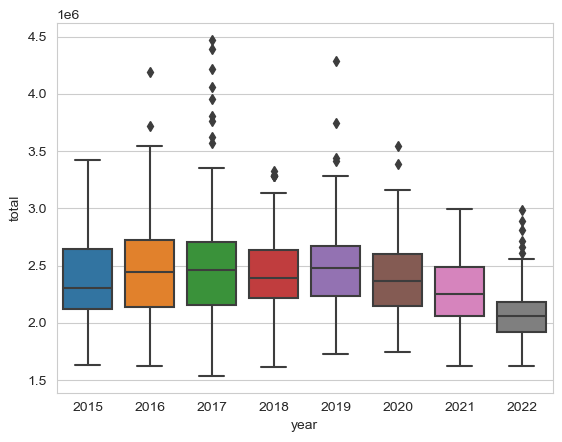

In [96]:
sns.boxplot(y=aggregation.total, x=aggregation.year)